In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version statsmodels: {sm.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version statsmodels: 0.14.6
- Version scikit-learn: 1.7.2
- Version pandas: 2.3.3
- Version numpy: 2.2.6


In [ ]:
try:
    df = pd.read_csv("../Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde '../Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [3]:
print("Dataset original - Columnas iniciales:")
print(f"Columnas: {list(df.columns)}")
print(f"Forma del dataset: {df.shape}")
print("\nPrimeras 3 filas:")
print(df.head(3))

Dataset original - Columnas iniciales:
Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Semestre', 'Accesos', 'Vacaciones?']
Forma del dataset: (511, 7)

Primeras 3 filas:
        Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones?
0  2023-12-14   14   12  2023         2      953            0
1  2023-12-15   15   12  2023         2      549            0
2  2023-12-16   16   12  2023         2       71            0


In [4]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

In [5]:
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [6]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
412,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
413,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
414,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
415,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
416,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


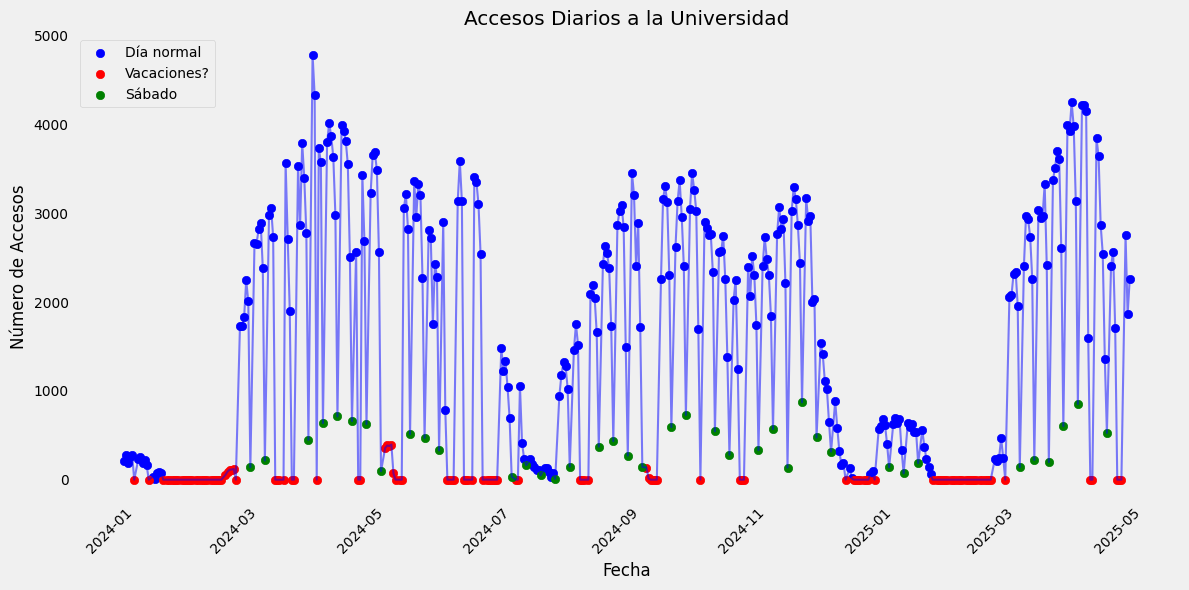

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

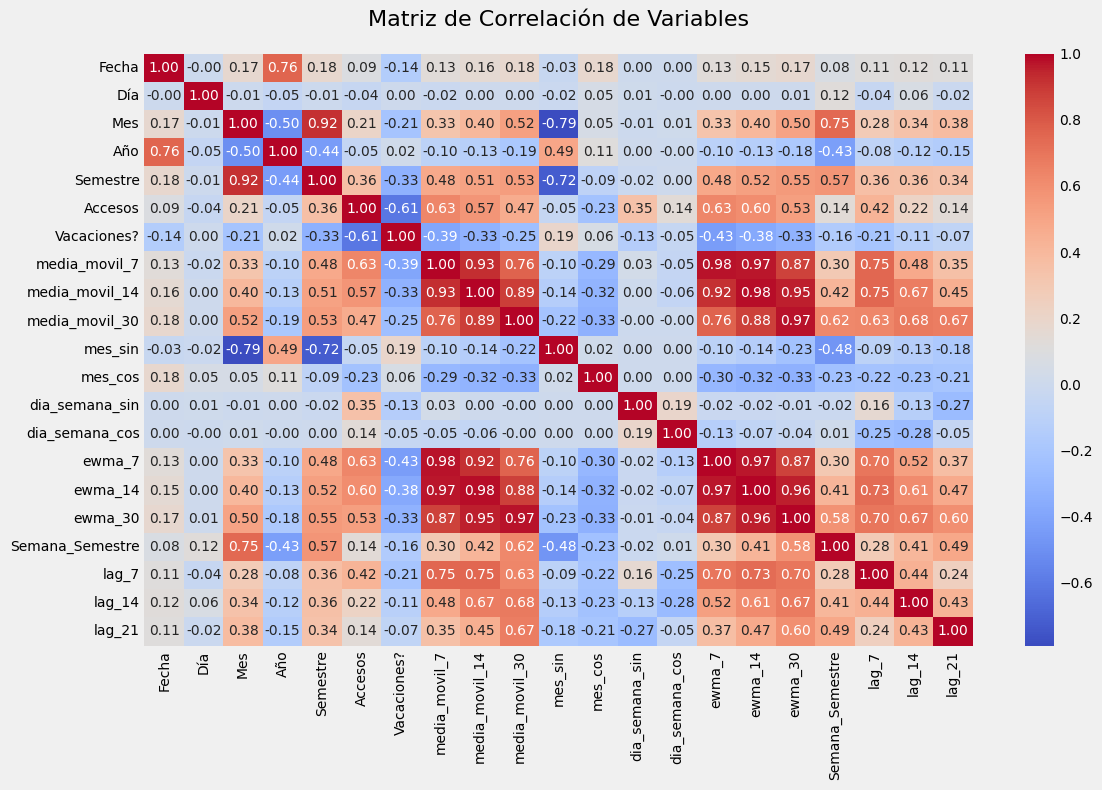

In [8]:
# Matriz de coorrelación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación de Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [9]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 333
Datos de prueba: 84


In [ ]:
os.makedirs('../Archivos Auxiliares', exist_ok=True)
if "modelo_SARIMAX.pkl" not in os.listdir('../Archivos Auxiliares'):
    print("Entrenando el modelo SARIMAX")
    p = d = q = range(0, 2)            
    P = D = Q = range(0, 2)
    s = 7                             

    y_train_log = np.log1p(y_train)

    pdq = list(product(p, d, q))
    seasonal_pdq = list(product(P, D, Q, [s]))

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = sm.tsa.SARIMAX(
                    y_train_log, exog=X_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False 
                )
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
            except:
                continue

    print(f"Mejor AIC encontrado: {best_aic:.2f}")
    print(f"Mejor Orden No Estacional (p, d, q): {best_order}")
    print(f"Mejor Orden Estacional (P, D, Q, s): {best_seasonal_order}")

    FINAL_ORDER = best_order if best_order else (0, 0, 1)
    FINAL_SEASONAL_ORDER = best_seasonal_order if best_seasonal_order else (1, 1, 1, 7)

    final_sarimax = sm.tsa.SARIMAX(
        y_train, exog=X_train, order=FINAL_ORDER, seasonal_order=FINAL_SEASONAL_ORDER,
        enforce_stationarity=False, enforce_invertibility=False
    )
    final_results = final_sarimax.fit(disp=False)
    print(final_results.summary().tables[1])
    joblib.dump(final_sarimax, '../Archivos Auxiliares/modelo_SARIMAX.pkl')
    print("Modelo guardado como '../Archivos Auxiliares/modelo_SARIMAX.pkl'")
else:
    final_results = joblib.load('../Archivos Auxiliares/modelo_SARIMAX.pkl')
    print("Modelo cargado desde '../Archivos Auxiliares/modelo_SARIMAX.pkl'")

Entrenando el modelo SARIMAX
Mejor AIC encontrado: 955.12
Mejor Orden No Estacional (p, d, q): (1, 0, 1)
Mejor Orden Estacional (P, D, Q, s): (0, 0, 1, 7)
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Día                 2.0413      9.875      0.207      0.836     -17.314      21.397
Mes               197.5654    229.289      0.862      0.389    -251.833     646.963
Año                 0.2905      0.233      1.246      0.213      -0.167       0.748
Semestre         -198.4925    738.138     -0.269      0.788   -1645.215    1248.230
Vacaciones?     -1282.8077    127.955    -10.025      0.000   -1533.594   -1032.021
media_movil_7       0.8489      0.429      1.980      0.048       0.009       1.689
media_movil_14      0.5845      0.830      0.705      0.481      -1.042       2.211
media_movil_30      1.0457      0.651      1.607      0.108      -0.229       2.321
mes_s

In [11]:
results_table = final_results.summary().tables[1] 

df_results = pd.DataFrame(results_table.data[1:], columns=results_table.data[0])
df_results = df_results.set_index(df_results.columns[0])

ALPHA = 0.05

exog_regressors = [col for col in X_train.columns]

drop_column = []

for regressor in exog_regressors:
    p_value_str = df_results.loc[regressor, 'P>|z|']
    p_value = float(p_value_str) 
        
    if p_value > ALPHA:
        drop_column.append(regressor)
    
if drop_column:
    X_train_filtered = X_train.drop(columns=drop_column)
    X_test_filtered = X_test.drop(columns=drop_column)
else:
    X_train_filtered = X_train
    X_test_filtered = X_test

final_sarimax = sm.tsa.SARIMAX(
    y_train, exog=X_train_filtered, order=FINAL_ORDER, seasonal_order=FINAL_SEASONAL_ORDER,
    enforce_stationarity=False, enforce_invertibility=False
)
final_results_filtered = final_sarimax.fit(disp=False)
    
print(final_results_filtered.summary().tables[1])
    

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Vacaciones?     -722.9433    124.883     -5.789      0.000    -967.710    -478.176
media_movil_7      0.9248      0.049     18.754      0.000       0.828       1.021
dia_semana_sin   626.1878     73.034      8.574      0.000     483.044     769.332
ar.L1              0.5470      0.102      5.337      0.000       0.346       0.748
ma.L1             -0.1440      0.112     -1.284      0.199      -0.364       0.076
ma.S.L7           -0.1437      0.054     -2.672      0.008      -0.249      -0.038
sigma2          7.166e+05   5.68e+04     12.612      0.000    6.05e+05    8.28e+05


In [12]:
print(final_results_filtered.summary()) 

                                     SARIMAX Results                                     
Dep. Variable:                           Accesos   No. Observations:                  333
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -2641.151
Date:                           Mon, 08 Dec 2025   AIC                           5296.302
Time:                                   18:02:58   BIC                           5322.767
Sample:                                        0   HQIC                          5306.865
                                           - 333                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Vacaciones?     -722.9433    124.883     -5.789      0.000    -967.710    -478.176
media_movil_7      0.9248      

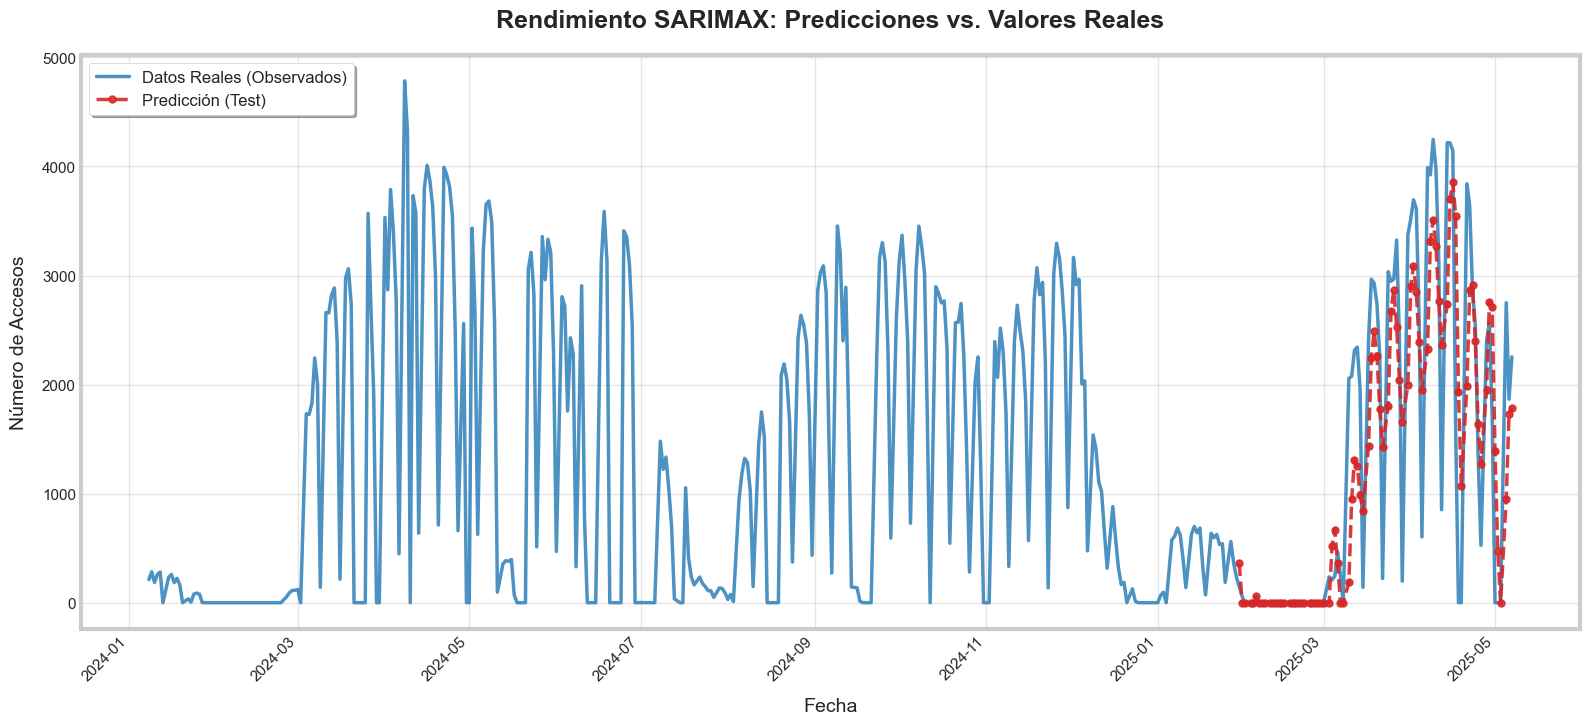


 Métricas de Evaluación en Set de Prueba
RMSE (Error Típico): 782.69
MAE (Error Absoluto): 529.60
R² (Varianza Explicada): 0.7346


In [ ]:
forecast_steps = len(y_test)
prediction = final_results_filtered.get_forecast(steps=forecast_steps, exog=X_test_filtered) 
pred_mean = prediction.predicted_mean
pred_mean = np.maximum(pred_mean, 0)

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8)) 

plt.plot(
    df['Fecha'],
    df['Accesos'],
    label='Datos Reales (Observados)',
    color='#1f77b4',
    linewidth=2.5,
    alpha=0.8
)

plt.plot(
    df['Fecha'].loc[X_test.index],
    pred_mean,
    label='Predicción (Test)',
    color='#d62728',
    linestyle='--',
    linewidth=2.5,
    marker='o',
    markersize=5,
    alpha=0.9
)

plt.xlabel('Fecha', fontsize=14, labelpad=10)
plt.ylabel('Número de Accesos', fontsize=14, labelpad=10)
plt.title(
    'Rendimiento SARIMAX: Predicciones vs. Valores Reales',
    fontsize=18,
    fontweight='bold',
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.grid(True, axis='both', linestyle='-', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

rmse = np.sqrt(mean_squared_error(y_test.values, pred_mean.values))
mae = mean_absolute_error(y_test.values, pred_mean.values)
r2 = r2_score(y_test.values, pred_mean.values)

print(f"RMSE (Error Típico): {rmse:.2f}")
print(f"MAE (Error Absoluto): {mae:.2f}")
print(f"R² (Varianza Explicada): {r2:.4f}")